 
<h1 align="center">🚀 PVXT - QA with Citations</h1>

----

## 🛠️ TLDR : Build 5 vision and text use cases with Claude 3 Sonnet on Amazon Bedrock:


- **1. Q&A with an AWS Architecture diagram** :
Learn how to integrate Claude 3 Sonnet into your AWS architecture to enhance AI capabilities. 🏗️

- **2 Automate Terraform script from AWS architecture diagram**:
Learn how to build a Terraform deployment with AWS architecture images using Claude 3 Sonnet. 🛠️

- **3. Side by Side Image Comparison**:
Discover the power of image comparison using Claude 3 Sonnet on Amazon Bedrock. 🖼️

- **4. Image Transcription**:
Explore the capabilities of image transcription with Claude 3 Sonnet on Amazon Bedrock. 📝

- **5. Streaming text reponse**:
Understand how to use Claude 3 Sonnet for streaming text responses. 📜

---

### Introduction to Claude 3

Anthropic unveils the Claude 3 model family, featuring Haiku, Sonnet, and Opus. 🌐

These models redefine AI capabilities, catering to diverse needs. Claude 3 Sonnet is available for immediate use on Amazon Bedrock, with Claude 3 Opus and Claude 3 Haiku coming soon. 💻

Claude 3 Sonnet strikes the ideal balance between intelligence and speed—particularly for enterprise workloads. It delivers robust performance at a lower cost compared to its peers and is engineered for high endurance in large-scale AI deployments. Moreover, it introduces image-to-text vision capabilities! 📸

**Potential uses**:
- Data processing: RAG or search & retrieval over vast amounts of knowledge 📚
- Sales: product recommendations, forecasting, targeted marketing 📈
- Time-saving tasks: code generation, quality control, parse text from images ⏰

**Differentiator**: More affordable than other models with similar intelligence; better for scale. 💰

**Key features**:

- 📊 **Context Window:** 200,000 tokens

- ⚡ **Speed:** 2x faster than Claude 2 and Claude 2.1

- 👁️ **Vision Capabilities:** Handles a wide range of visual formats, including photos, charts, graphs, and technical diagrams.

- 🚫 **Refusals:** Claude 3 models (including Sonnet) significantly reduce unnecessary refusals compared to previous generations.

- 🛡️ **Safety Level:** Maintains AI Safety Level 2 (ASL-2) per the Responsible Scaling Policy.

- 🚀 **Model Speed Comparison:** Sonnet is 2x faster than Claude 2 and Claude 2.1, excelling at tasks demanding rapid responses.


### Pre-requisites:

- **AWS Account**: To use Amazon Bedrock and deploy the use cases.
- **AWS Credentials**: Make sure your credientials are configured in your environment. More details [here](https://handsonaws.com/blog/advanced-awscli-notebooks-iam-s3-cross-account/)

If you have a AWS profile configured in your environment, you can use the following magic commands to set the profile and rehash the environment variables:

```bash 
%env AWS_PROFILE = your_profile
%rehashx
%automagic 1
```
- **Amazon Bedrock permissions** : Amazon Bedrock IAM permissions to run this notebook. More details [here](https://docs.aws.amazon.com/bedrock/latest/userguide/iam-permissions.html)

Enable AWS IAM permissions for Bedrock
The AWS identity you assume from your notebook environment (which is the Studio/notebook Execution Role from SageMaker, or could be a role or IAM User for self-managed notebooks), must have sufficient AWS IAM permissions to call the Amazon Bedrock service.

To grant Bedrock access to your identity, you can:

Open the AWS IAM Console
Find your Role (if using SageMaker or otherwise assuming an IAM Role), or else User
Select Add Permissions > Create Inline Policy to attach new inline permissions, open the JSON editor and paste in the below example policy:


```json 
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "BedrockFullAccess",
            "Effect": "Allow",
            "Action": ["bedrock:*"],
            "Resource": "*"
        }
    ]
}
```



### Use case 1: Q&A with an AWS Architecture diagram using Claude 3 Sonnet on Amazon Bedrock

In this use case, we will explore how to integrate Claude 3 Sonnet to help you answer questions about your AWS architecture. This can be particularly useful for large-scale deployments, where it can be challenging to keep track of all the moving parts.




In [1]:
# Install latest version of boto3
!pip --quiet install boto3==1.33.2 termcolor matplotlib ipython


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.32.50 requires botocore==1.34.50, but you have botocore 1.33.13 which is incompatible.
awscli 1.32.50 requires s3transfer<0.11.0,>=0.10.0, but you have s3transfer 0.8.2 which is incompatible.
sagemaker 2.209.0 requires boto3<2.0,>=1.33.3, but you have boto3 1.33.2 which is incompatible.


In [2]:
import base64, re,json
import boto3
from termcolor import colored
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from IPython.display import display, Image


In [3]:
def image_to_base64(image_path):
    with open(image_path, 'rb') as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


def display_image(image_path):
    with open(image_path, "rb") as image_file:
        display(Image(data=image_file.read()))

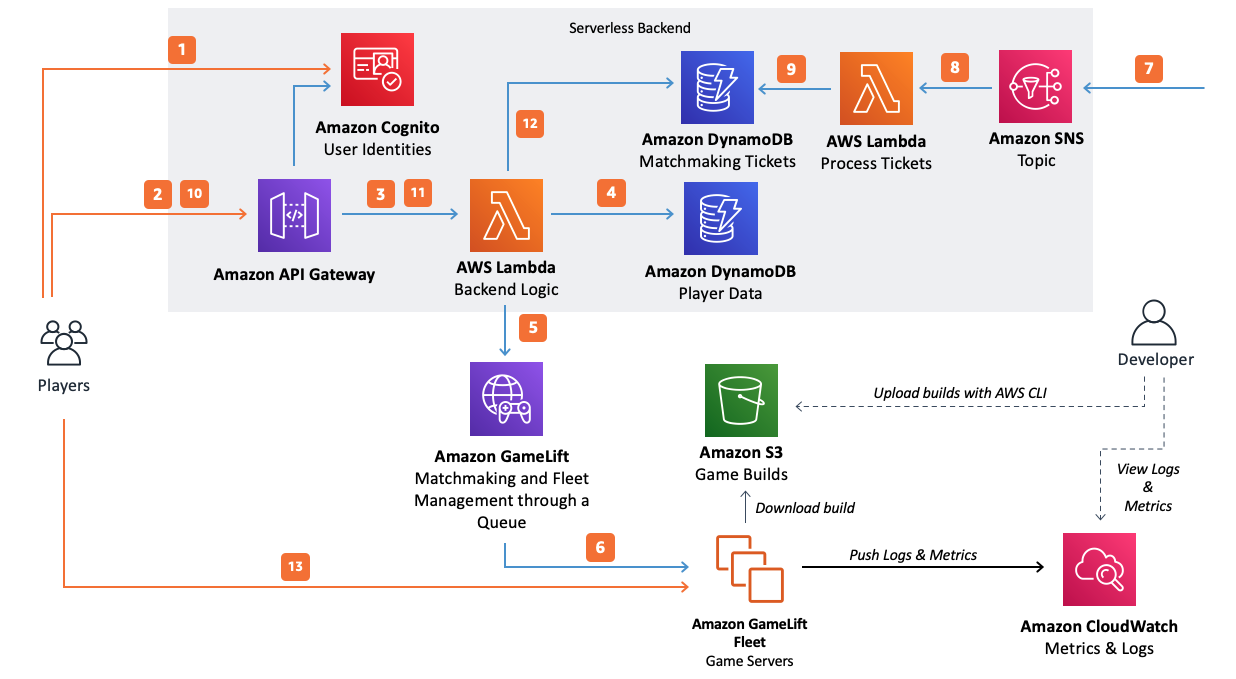

In [4]:
display_image("images/architecture.png")

The Claude 3 family of models comes with new vision capabilities that allow Claude to understand and analyze images, opening up exciting possibilities for multimodal interaction. With Claude, you can now provide both text and image inputs to enrich your conversations and enable powerful new use cases.


To utilize images when making an API request, you can provide images to Claude as a ``base64-encoded`` image in image content blocks. Here is simple example in Python showing how to include a base64-encoded image in a Messages API request:

```python
messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": image1_media_type,
                        "data": image1_data,
                    },
                },
                {
                    "type": "text",
                    "text": "Describe this image."
                }
            ],
        }
    ],
```

Supported image formats are ``JPEG, PNG, GIF, and WebP``. See Messages [API examples](https://docs.anthropic.com/claude/reference/messages_post) for more example code and parameter details.

Below we defined two funtions to help you get started with image processing using Claude 3 Sonnet on Amazon Bedrock:

- ``post_process_answer()`` : This function extracts answer from the Bedrock API response. A best pratice frome [Claude prompt engineering](https://docs.anthropic.com/claude/docs/prefill-claudes-response) is to output the answer inside <answer></answer> XML tags. This function will extract the answer from the API response.
- ``generate_vision_answer()`` : This function will generate the API request to send the image to the Claude 3 Sonnet model to Amazon Bedrock. 




In [5]:
def post_process_answer(response:str)->str:
    """
    Extracts the answer from the given response string.

    Args:
        response (str): The response string containing the answer.

    Returns:
        str: The extracted answer.
    """
    answer = re.findall(r'<answer>(.*?)</answer>', response, re.DOTALL)
    return answer[0]

def generate_vision_answer(bedrock_rt:boto3.client,messages:list, model_id:str, claude_config:dict,system_prompt:str):
    """
    Generates a vision answer using the specified model and configuration.
    
    Parameters:
    - bedrock_rt (boto3.client): The Bedrock runtime client.
    - messages (list): A list of messages.
    - model_id (str): The ID of the model to use.
    - claude_config (dict): The configuration for Claude.
    - system_prompt (str): The system prompt.
    
    Returns:
    - str: The formatted response.
    """
    
    body={'messages': [messages],**claude_config, "system": system_prompt}
    
    response = bedrock_rt.invoke_model(modelId=model_id, body=json.dumps(body))   
    response = json.loads(response['body'].read().decode('utf-8'))
    formated_response= post_process_answer(response['content'][0]['text'])
    
    return formated_response

In this use case, the goal is to ask a question about the AWS architecture and provide an image of the architecture. The image will be sent to the Claude 3 Sonnet model to generate a response. The response will be post-processed to extract the answer.

To perform this task, we need a **system prompt**. This is a way of providing context and instructions to Claude, such as specifying a particular goal or role. See our guide to system prompts.

An example system prompt for this use case could be:

```
You have perfect vision and pay great attention to detail which makes you an expert at answering architecture diagram question
```

In [6]:
%%time

# Create a bedrock runtime client in us-west-2
bedrock_rt = boto3.client("bedrock-runtime", region_name="us-east-1")



# Model id and claude config
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
claude_config = {
    'max_tokens': 1000, 
    'temperature': 0, 
    'anthropic_version': '',  
    'top_p': 1, 
    'stop_sequences': ['Human:']
}

# Create prompt and system prompt
system_prompt= "You have perfect vision and pay great attention to detail which makes you an expert at answering architecture diagram question. Answer question in <question></question> tags. Before answer, think step by step in <thinking> tags and analyze every part of the diagram."

#Create a prompt with the question
prompt = f"<question>Explain why Amazon Gamelift is usefull on the diagram </question>. Answer must be a numbered list in a small paragraph inside <answer></answer> tag."

# Create message with the prompt and the base64 encoded image
messages={"role": "user", "content": [
{
        "type": "image",
        "source": {
        "type": "base64",
        "media_type": "image/jpeg",
        "data": image_to_base64("images/architecture.png"),
        }
},
{"type": "text", "text": prompt}
]}

# Generate answer
answer=generate_vision_answer(bedrock_rt, messages, model_id, claude_config, system_prompt)    
print(colored(answer, "green"))



Amazon GameLift is useful in this diagram for the following reasons:

1. It provides matchmaking and fleet management services through a queue system, allowing players to be matched and connected to game servers efficiently.

2. It integrates with other AWS services like Lambda for backend logic, DynamoDB for storing player data and matchmaking tickets, and S3 for storing game builds. This allows for a seamless serverless architecture.

3. By offloading the management of game servers to GameLift, the system can scale resources dynamically based on demand, reducing operational overhead and costs compared to managing servers manually.

4. GameLift's fleet of game servers can push logs and metrics to Amazon CloudWatch, enabling monitoring and analysis of the system's performance and health.

CPU times: user 93.5 ms, sys: 14.5 ms, total: 108 ms
Wall time: 7.14 s


### Use Case 2: Automate Terraform script from AWS architecture diagram using Claude 3 Sonnet on Amazon Bedrock

In this use case, we will explore how to use Claude 3 Sonnet to generate a Terraform script from an AWS architecture image. This can be particularly useful for automating the deployment of AWS infrastructure. It will greatly reduce the time and effort required to create Terraform scripts from AWS architecture images.


Here is a simple serveless architectiure diagram that we will use as an example:


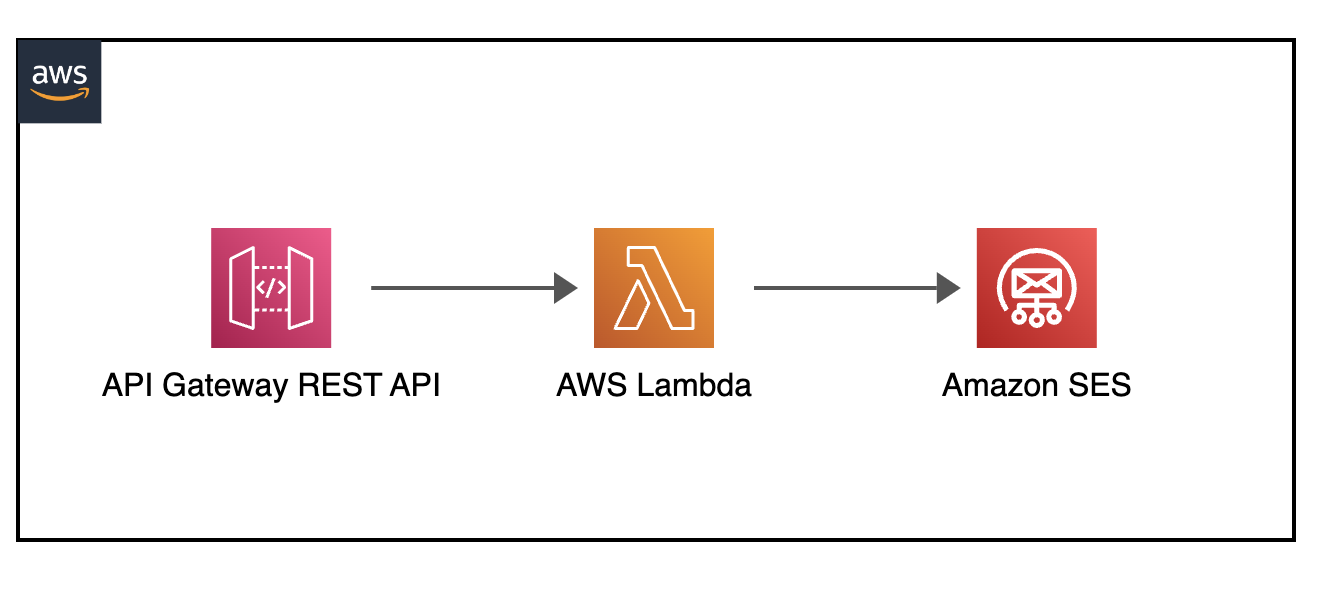

In [7]:
display_image("images/serverless.png")

In [8]:
system_prompt=""
messages = {    
    "role": "user",
    "content": [
        {
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": "image/jpeg",
                "data": image_to_base64("images/serverless.png")
            }
        },
        {
            "type": "text",
            "text": "Describe the architecture and code terraform script to deploy it, answer inside <answer></answer> tags."
        }
    ]
}

# Generate answer
answer= generate_vision_answer(bedrock_rt, messages, model_id, claude_config, system_prompt="")
print(colored(answer, "green"))


The architecture shown in the image depicts a serverless application deployment on AWS using the following components:

1. API Gateway REST API: This acts as the entry point for the application, receiving incoming HTTP requests and routing them to the appropriate AWS Lambda function.

2. AWS Lambda: This is a serverless compute service that runs your application code in response to events or requests, without the need to provision or manage servers.

3. Amazon SES (Simple Email Service): This is an email service that allows you to send and receive emails from your application.

To deploy this architecture using Terraform, you would need to create the following resources:

1. AWS API Gateway REST API resource
2. AWS Lambda function resource
3. AWS SES resource (if you need to send emails)
4. AWS IAM role and policy resources to grant necessary permissions

Here's a basic Terraform script to deploy this architecture:

```hcl
# Configure AWS provider
provider "aws" {
  region = "us-west-

### Use case 3:  Side by side image comparaison using Claude 3 Sonnet on Amazon Bedrock

In this use case, we will explore how to use Claude 3 Sonnet to compare two images side by side. This can be particularly useful for quality control and identifying differences between two images.

#### Let's play a game!

Can you spot the differences between the two images below?


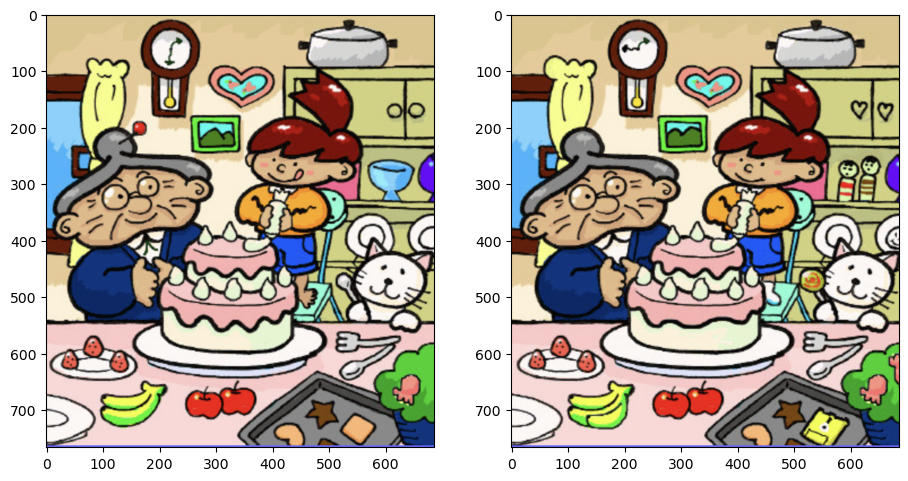

In [9]:
%matplotlib inline

local_images = ["images/image_1.png", "images/image_2.png"]

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# read images
img_A = mpimg.imread(local_images[0])
img_B = mpimg.imread(local_images[1])

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

In [10]:
%%time
import base64

list_images_base64 = []
local_images = ["images/image_1.png", "images/image_2.png"]


system_prompt="You have perfect vision and pay great attention to detail which makes you an expert at finding differences between images. Answer question in <question></question> tags, answer must be inside <answer></answer> tag. Before answer,  Think step by step in <thinking> tags and analyze every part of the image."
prompt="List all difference between the two pictures ?"
messages={"role": "user", "content": [
        {
                    "type": "text",
                    "text": "Image 1:"
            },
        {
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": "image/jpeg",
                "data": image_to_base64(local_images[0]),
            }
        },
        {
            "type": "text",
            "text": "Image 2:"
        },
        {
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": "image/jpeg",
                "data": image_to_base64(local_images[1]),
            }
        },
        {"type": "text", "text": prompt}
    ]}
# Generate answer
answer= generate_vision_answer(bedrock_rt, messages, model_id, claude_config, system_prompt)    
print(colored(answer, "green"))


The differences between the two images are:

1. The clock in the top left shows a different time in each image. In Image 1, it shows a straight line, while in Image 2, it shows a curved line resembling a frown.

2. On the stove in the bottom right, there is a yellow square shape in Image 2 that is not present in Image 1.

3. On the cabinet in the bottom right, there are two heart shapes in Image 2 instead of the single smiley face in Image 1.

CPU times: user 25.6 ms, sys: 4.05 ms, total: 29.6 ms
Wall time: 5.94 s


### Use Case 4: Image Transcription with Claude 3 Sonnet on Amazon Bedrock 

In this use case, we will explore how to use Claude 3 Sonnet to transcribe text from an image. This can be particularly useful for extracting text from:

1. Images
2. Charts
3. Diagram
4. Technical Drawings


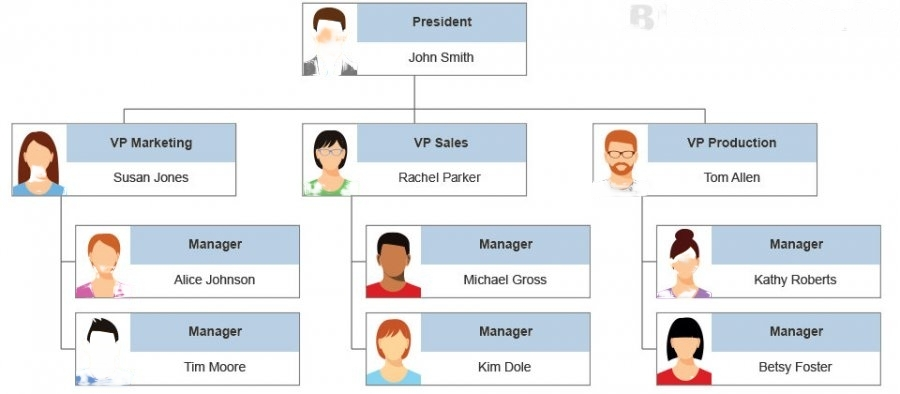

In [11]:
display_image("images/organigram.jpeg")

In [12]:
messages = {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/jpeg", "data": image_to_base64("images/organigram.jpeg")}},
            {"type": "text", "text": "Turn this org chart into JSON indicating who reports to who, answer inside <answer></answer> tags."}
        ]
    }

# Generate answer
answer= generate_vision_answer(bedrock_rt, messages, model_id, claude_config, system_prompt="")
print(colored(answer, "green"))


{
  "President": "John Smith",
  "VPs": [
    {
      "title": "VP Marketing",
      "name": "Susan Jones",
      "managers": [
        "Alice Johnson",
        "Tim Moore"
      ]
    },
    {
      "title": "VP Sales",
      "name": "Rachel Parker",
      "managers": [
        "Michael Gross",
        "Kim Dole"
      ]
    },
    {
      "title": "VP Production",
      "name": "Tom Allen",
      "managers": [
        "Kathy Roberts",
        "Betsy Foster"
      ]
    }
  ]
}



### Use Case 5: Streaming Text with Claude 3 Sonnet on Amazon Bedrock

In this use case, we'll explore how to harness the power of Claude 3 Sonnet to stream text. This functionality proves particularly beneficial for:

- Real-time updates
- Live conversations
- Dynamic content generation
- Continuous text processing


In [13]:
#Streaming with Bedrock 3


def stream_answer(bedrock_rt:boto3.client, model_id:str, claude_config:dict, prompt:str):
    stream_answer={"role": "user", "content": prompt}
    
    body={'messages': [stream_answer],**claude_config}
    response = bedrock_rt.invoke_model_with_response_stream(modelId=model_id, body=json.dumps(body))
    response_stream = response.get('body')
    for event in response_stream or []:
        chunk_data = event.get('chunk')
        if chunk_data:
            chunk_obj = json.loads(chunk_data.get('bytes').decode())
            delta = chunk_obj.get('delta', {})
            text_content = delta.get('text', "")
            yield str(text_content)

In [14]:
file = open ("data/pvxt-wiki.txt", "r")
context = file.read()
prompt="""

Human: I'm going to give you a document. Then I'm going to ask you a question about it. I'd like you to first write down exact quotes of parts of the document that would help answer the question, and then I'd like you to answer the question using facts from the quoted content. Here is the document:

"""
prompt= prompt + context + """
First, find the quotes from the document that are most relevant to answering the question, and then print them in numbered order. Quotes should be relatively short.

If there are no relevant quotes, write "No relevant quotes" instead.

Then, answer the question, starting with "Answer:". Do not include or reference quoted content verbatim in the answer. Don't say "According to Quote [1]" when answering. Instead make references to quotes relevant to each section of the answer solely by adding their bracketed numbers at the end of relevant sentences.

Thus, the format of your overall response should look like what's shown between the  tags. Make sure to follow the formatting and spacing exactly.


Relevant quotes:
[1] "Ted Trombley
tedtromb@
TPM
Linear TPM lead
Key Contributor for Linear CPR (new capabilities
Linear Issue management & Reporting
Linear execution roadmap & planning
Linear Video Quality & Encoding
New capability and feature rollout for Linear
Tech approaches, Operational Readiness docs, Launch Plans
Linear Geography expansion
Partner management
Business docs: MBR, QPR
Key projects: AHA, Location Based Viewing, Blackouts, Channels Expansion
Key partners: Elemental, PV Sports, PV Channels, PV UX
Key Vendors: Zixi"
[2] 

Answer: 
Ted Trombley is the TPM Lead for Linear and his responsibilities are as follows
Key Contributor for Linear CPR (new capabilities
Linear Issue management & Reporting
Linear execution roadmap & planning
Linear Video Quality & Encoding
New capability and feature rollout for Linear
Tech approaches, Operational Readiness docs, Launch Plans
Linear Geography expansion
Partner management
Business docs: MBR, QPR
Key projects: AHA, Location Based Viewing, Blackouts, Channels Expansion
Key partners: Elemental, PV Sports, PV Channels, PV UX
Key Vendors: Zixi


Here is the first question: In bullet points and simple terms, who is the leader of Playback experience tech product and program management?

If the question cannot be answered by the document, say so.

Answer the question immediately without preamble.


"""

for answer in stream_answer(bedrock_rt, model_id, claude_config, prompt):
    print(answer,end="")

[1] "Olivier Wellmann
wellmo@
Director
Director of Product and Program Management 
[3-year vision], [OP], [PRFAQ], [BRD], [QPR], [MBR], [CPR/WBR], [KPI]
Video Playback Product Strategy across Amazon Business Cadence (3YP, OP, QPR)
Product Roadmap and Execution for Video Playback
Technical Product Management Leader
Technical Program Management Leader
Product Goals for Playback
Recruiting, coaching, and mentoring
Product and Program Escalation"

Answer:
- Olivier Wellmann is the Director of Product and Program Management for Playback Experience Tech
- He is responsible for the 3-year vision, operating plans, product requirements, business requirements, quarterly plans, monthly plans, product/program reviews, and KPIs
- He leads the product strategy, roadmap, and execution for video playback
- He is the leader for both technical product management and technical program management
- He sets the product goals for playback
- He handles recruiting, coaching, mentoring, and escalations for pro

#### <span style="color:#3498db">Optional: Put Words in Claude's Mouth</span>

**Why prefill Claude's response?**

Prefilling Claude's response offers several key benefits:
- **Increased steerability**: By providing some initial text for Claude to continue from, you can steer Claude's response in a desired direction. This is particularly useful when you want Claude to focus on a specific topic, generate a particular type of content, or act a certain way.

- **Control output format**: Prefilling allows you to specify the exact format you want Claude to use for its output. This is especially handy when working with structured data formats like JSON or XML. For more details on this, see our guide on controlling output format.

- **Maintain character consistency**: In role-play scenarios, prefilling Claude's response can help Claude stay in character throughout a long conversation. By consistently reminding Claude of its role in the Assistant message, you can better ensure that Claude maintains the desired persona. Check out keep Claude stay in character for more details.


In [15]:

def generate_answer(bedrock_rt:boto3.client, prompt:str, model_id:str, claude_config:dict,system_prompt:str)->str:
    

    message={'messages': [{"role": "user", "content": prompt},
                          {"role": "assistant", "content": "The answer is"}]}
    
    body={**message,**claude_config, "system": system_prompt}
    
    response = bedrock_rt.invoke_model(modelId=model_id, body=json.dumps(body))
    response = json.loads(response['body'].read().decode('utf-8'))
    return response['content'][0]['text']

In [23]:
file = open ("data/pvxt-wiki.txt", "r")
context = file.read()
system_prompt="""

Human: I'm going to give you a document. Then I'm going to ask you a question about it. I'd like you to first write down exact quotes of parts of the document that would help answer the question, and then I'd like you to answer the question using facts from the quoted content. Here is the document:

"""
system_prompt= system_prompt + context + """

First, find the quotes from the document that are most relevant to answering the question, and then print them in numbered order. Quotes should be relatively short.

If there are no relevant quotes, write "No relevant quotes" instead.

Then, answer the question, starting with "Answer:". Do not include or reference quoted content verbatim in the answer. Don't say "According to Quote [1]" when answering. Instead make references to quotes relevant to each section of the answer solely by adding their bracketed numbers at the end of relevant sentences.

Thus, the format of your overall response should look like what's shown between the  tags. Make sure to follow the formatting and spacing exactly.


Relevant quotes:
[1] "Ted Trombley
tedtromb@
TPM
Linear TPM lead
Key Contributor for Linear CPR (new capabilities
Linear Issue management & Reporting
Linear execution roadmap & planning
Linear Video Quality & Encoding
New capability and feature rollout for Linear
Tech approaches, Operational Readiness docs, Launch Plans
Linear Geography expansion
Partner management
Business docs: MBR, QPR
Key projects: AHA, Location Based Viewing, Blackouts, Channels Expansion
Key partners: Elemental, PV Sports, PV Channels, PV UX
Key Vendors: Zixi"
[2] 

Answer: 
Ted Trombley is the TPM Lead for Linear and his responsibilities are as follows
Key Contributor for Linear CPR (new capabilities
Linear Issue management & Reporting
Linear execution roadmap & planning
Linear Video Quality & Encoding
New capability and feature rollout for Linear
Tech approaches, Operational Readiness docs, Launch Plans
Linear Geography expansion
Partner management
Business docs: MBR, QPR
Key projects: AHA, Location Based Viewing, Blackouts, Channels Expansion
Key partners: Elemental, PV Sports, PV Channels, PV UX
Key Vendors: Zixi


"""

prompt="""
Here is the first question: In bullet points and simple terms, who is the leader of Playback experience tech product and program management?

If the question cannot be answered by the document, say so.

Answer the question immediately without preamble.
"""
response=generate_answer(bedrock_rt, prompt, model_id, claude_config,system_prompt)
print(colored(response, "green"))

:

- Olivier Wellmann (wellmo@) is the Director of Product and Program Management for Playback Experience Tech.

His responsibilities include:

- 3-year vision, OP (Operating Plan), PRFAQ (Frequently Asked Questions), BRD (Business Requirements Document), QPR (Quarterly Program Review), MBR (Monthly Business Review), CPR/WBR (Commitment/Work-back Review), KPI (Key Performance Indicators)
- Video Playback Product Strategy across Amazon Business Cadence
- Product Roadmap and Execution for Video Playback
- Technical Product Management Leader
- Technical Program Management Leader
- Product Goals for Playback
- Recruiting, coaching, and mentoring
- Product and Program Escalation


In [24]:
prompt="Who owns Live and Linear Technical Programs?"
response=generate_answer(bedrock_rt, prompt, model_id, claude_config,system_prompt)
print(colored(response, "green"))

 provided in this quote:

[1] "Navinan Rajeswaran
navinanr@
TPM
Head of Technical programs for Live & Linear
PV alignment for priority, intake and resourcing
Execution roadmap for Live & Linear
Mechanisms for delivery, quality assurance, launches, operations and reporting
Escalation point of contact for Live & Linear
Tech approaches, Execution Strategy, Tech and Operational Deep Dives
Relationship management for Live and Linear delivery (PV, Amazon, Vendors)
Sye & Ads Integration for Live
Key docs: TNF overall, Live & Linear execution roadmap
Key projects: TNF lead, Audio Lab
Key partners: PV Sports, PV UX, Partner Engineering, AWS"

Navinan Rajeswaran is the Head of Technical Programs for Live & Linear. His responsibilities include alignment on priorities and resourcing, execution roadmap, delivery mechanisms, escalation point of contact, technical approaches and strategy, relationship management with partners and vendors, and key projects like TNF and Audio Lab. [1]


In [25]:
prompt="What are the team's tenets?"
response=generate_answer(bedrock_rt, prompt, model_id, claude_config,system_prompt)
print(colored(response, "green"))

 based on the following quotes from the document:

[1] "Our Tenets (Unless You Know Better...)
We willingly adopt Audio/Video (A/V) streaming standards and implement them at scale. We invent new A/V tech without constraints on behalf of our customers, influencing original equipment manufacturers (OEM), content delivery networks (CDN), internet service providers (ISP), industry partners, and standards bodies to adopt our proposals and innovate with us. We do not merely adopt emerging tech. We strive to invent them."

[2] "We operate our services by continually improving 1) reliability and availability, 2) video experience and picture quality, and 3) new customer-facing capabilities. When we have to make tradeoffs, we prioritize in the order listed."

[3] "We design our services with multi-tenancy and decoupling in mind. Our stakeholders shouldn't rely on us to deliver for their customers. When we slow them down, we'll take a step back and assess how to enable them to move fast and incre

In [26]:
prompt="What does the QoE team do?"
response=generate_answer(bedrock_rt, prompt, model_id, claude_config,system_prompt)
print(colored(response, "green"))

 based on these relevant quotes:

[1] "At Prime Video, we serve Live, Linear, and VOD streaming through multiple 1p and 3p channels to customers world-wide on a multitude of devices using various internet providers/infrastructure. Historically, Prime Video has measured the success of our customer quality of experience by a set of KPI's based on calculations using sums & averages at the stream level implying all streams impact the customer equally. This program (Farpoint) will challenge that assumption by zooming in on a set of measures that distill the impact to a combination of customer, location, ISP, and device related experience to better address the bulk of customers that we can further delight."

[2] "Our team also owns the Page 0 metrics for Prime Video Playback that are used to regularly measure the progress toward the yearly goals. To drive this, we focus on these key areas: 1) Metric alignment with PV OP1/OP2 goals by working with DVPI to ensure the correct metrics are surfac

In [27]:
prompt="Who should I reach out for analytics in the team?"
response=generate_answer(bedrock_rt, prompt, model_id, claude_config,system_prompt)
print(colored(response, "green"))

 based on these relevant quotes:

[1] "Asher Wittenberg
ahw@
PMT
Principal Product Manager Tech, Playback Analytics & Playback Optimization 
[3 year vision], [OP], [PRFAQ], [BRD], [QPR], [MBR], required in [CPR/WBR], [KPI]
Data Collection (Playback Telemetry)
Playback QoE Performance Metrics & Ad QoE Measurement
Playback Feature Analytics
Playback QoE Anomaly Detection (Auror)
Playback Analytics Decoupling
Playback Analytics Tools (Sauron)
Automated Data Quality Issue Detection, Prioritization, & Mitigation
Playback Data Privacy & Security
Playback Datasets, Integrations, & APIs
Last Mile Issue Detection, Mitigation, & Customer Messaging (Sonar)
Next-gen Continuous Optimization for Video Heuristics 
Playback Heuristic Treatment Generation, Promotion Service, & Player Simulator
Content & Context Aware Heuristics Optimization
Playback Optimization Algorithms & Science Initiatives
Playback Intake Request Mechanism Owner"

Answer: For analytics related to playback, you should reach out to 

In [28]:
prompt="What does the Live event and Linear Operations team do and who are the members of it?"
response=generate_answer(bedrock_rt, prompt, model_id, claude_config,system_prompt)
print(colored(response, "green"))

 based on the following relevant quotes from the document:

[1] "Live Event & Linear, Live Operations & Monitoring, VOD Encoding & AV Quality
Live Events & Linear: The Live Event and Linear Product Teams owns the live events and linear product offerings for Playback. Our mission is to build and operate the world's most innovative live video streaming technology stack, providing a customer-centric live streaming experience. Our desire is to set the bar for the industry and position PV as the top streaming service in the world by being significantly better than broadcast TV in terms of availability, quality, reliability, and scale for live streaming."

[2] "Live Operations & Monitoring: The Live Operations and Live Monitoring Product teams owns the operation and end-to-end monitoring of all Live events and Linear stations on Prime Video. The program ensures we can rapidly onboard and operate events and linear stations at scale, including automation (all processes from pre-event to post-e

In [29]:
prompt="Who should I reach out for CDN Load Balancer?"
response=generate_answer(bedrock_rt, prompt, model_id, claude_config,system_prompt)
print(colored(response, "green"))

 Eric Boyd (byde@). Here are the relevant quotes:

[1] "Eric Boyd
byde@
Sr. Mgr Product
Sr. Manager Product, Playback Services and Video Delivery
Product lead for video delivery and play start services that deliver playable streams to customers world-wide
...
Next generation CDN Load Balancer (Project Serena)"

[2] "CDN edge authorization (Edge tokenization)
Granular Session Routing and optimized CDN URLs (UTS, GSR)
Next generation CDN Load Balancer (Project Serena)"

Answer: You should reach out to Eric Boyd (byde@) for questions or issues related to the CDN Load Balancer, specifically Project Serena which is the next generation CDN Load Balancer. Eric is the Sr. Manager of Product for Playback Services and Video Delivery, which includes the CDN Load Balancer as one of the areas he oversees. [1,2]
